# <u>Detecting Signature Similarity using Tensorflow 2 (By Aadit Kapoor).</u>
<p>
    My Grandfather was an handwriting expert. His work consisted of anazlying/verifying forged and real signatures. While I agree that we cannot replace that job with an A.I with a 100% accuracy, we certanily build a system capable of aiding human beings.
</p>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score
import seaborn as sns
from shutil import copy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random
import os

np.random.seed(42)

DATA_DIR = "Dataset"

In [2]:
!git clone https://github.com/mohanrajmit/SignatureVerification.git

Cloning into 'SignatureVerification'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 6 (delta 0), reused 3 (delta 0), pack-reused 3
Unpacking objects: 100% (6/6), done.


In [3]:
!unzip /content/SignatureVerification/Dataset.zip

Archive:  /content/SignatureVerification/Dataset.zip
   creating: Dataset/dataset1/
   creating: Dataset/dataset1/forge/
  inflating: Dataset/dataset1/forge/02100001.png  
  inflating: Dataset/dataset1/forge/02100002.png  
  inflating: Dataset/dataset1/forge/02100003.png  
  inflating: Dataset/dataset1/forge/02100004.png  
  inflating: Dataset/dataset1/forge/02100005.png  
  inflating: Dataset/dataset1/forge/02100006.png  
  inflating: Dataset/dataset1/forge/02100007.png  
  inflating: Dataset/dataset1/forge/02100008.png  
  inflating: Dataset/dataset1/forge/02100009.png  
  inflating: Dataset/dataset1/forge/02100010.png  
  inflating: Dataset/dataset1/forge/02100011.png  
  inflating: Dataset/dataset1/forge/02100012.png  
  inflating: Dataset/dataset1/forge/02101001.png  
  inflating: Dataset/dataset1/forge/02101002.png  
  inflating: Dataset/dataset1/forge/02101003.png  
  inflating: Dataset/dataset1/forge/02101004.png  
  inflating: Dataset/dataset1/forge/02101005.png  
  inflating:

# <u>The Dataset</u>
- We will be using the handwritten signatures dataset from Kaggle. (https://www.kaggle.com/divyanshrai/handwritten-signatures)
- Like any project, we will first start by exploring and loading the data.

In [4]:
def load_data(DATA_DIR=DATA_DIR, test_size=0.2, verbose=True, load_grayscale=True):
    """
        Loads the data into a dataframe.
        
        Arguments:
            DATA_DIR: str
            test_size: float
        Returns:
            (x_train, y_train,x_test, y_test, x_val, y_val, df)
    """
    features = []
    features_forged = []
    features_real = []
    features_dict = {}
    labels = [] # forged: 0 and real: 1
    mode = "rgb"
    if load_grayscale:
        mode = "grayscale"
    
    for folder in os.listdir(DATA_DIR):
        # forged images
        if folder == '.DS_Store' or folder == '.ipynb_checkpoints':
            continue
        print ("Searching folder {}".format(folder))
        for sub in os.listdir(DATA_DIR+"/"+folder+"/forge"):
            f = DATA_DIR+"/"+folder+"/forge/" + sub
            img = load_img(f,color_mode=mode, target_size=(150,150))
            features.append(img_to_array(img))
            features_dict[sub] = (img, 0)
            features_forged.append(img)
            if verbose:
                print ("Adding {} with label 0".format(f))
            labels.append(0) # forged
        # real images
        for sub in os.listdir(DATA_DIR+"/"+folder+"/real"):
            f = DATA_DIR+"/"+folder+"/real/" + sub
            img = load_img(f,color_mode=mode, target_size=(150,150))
            features.append(img_to_array(img))
            features_dict[sub] = (img, 1)
            features_real.append(img)
            if verbose:
                print ("Adding {} with label 1".format(f))
            labels.append(1) # real
            
    features = np.array(features)
    labels = np.array(labels)
    
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
    
    print ("Generated data.")
    return features, labels,features_forged, features_real,features_dict,x_train, x_test, y_train, y_test, x_val, y_val


def convert_label_to_text(label=0):
    """
        Convert label into text
        
        Arguments:
            label: int
        Returns:
            str: The mapping
    """
    return "Forged" if label == 0 else "Real"

In [6]:
features, labels,features_forged, features_real, features_dict,x_train, x_test, y_train, y_test, x_val, y_val = load_data(verbose=False, load_grayscale=False)

Searching folder dataset3
Searching folder dataset1
Searching folder dataset2
Searching folder dataset4
Generated data.


- We extract all the data in the respective variables where 0 label stands for forged and 1 stands for real.
- The images are loaded with as channels as 1 (grayscale)

# <u>Visualization of the data</u>
- Let us get a closer look at the data.

# <u>Approach #2: Building a classifier using CNNs that can detect forged or real signatures.</u>
<p>
    With this approach, we will try to come up with a classifier (using CNNs) to detect forged or real signatures.<br>
    As CNNs are known to detect intricate features among images, we will experiment with a this classifier.
</p>

- We are bound to encounter with overfitting as we do not have enough data.
- We will probably use Image Augementation to generate more training data.

In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3,3), input_shape=(150,150,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2))
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2))
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['acc'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 16)       0

In [9]:
# normalize inputs
x_train /= 255.
x_val /= 255.
x_test /= 255.

In [10]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
14/14 [==============================] - 12s 68ms/step - loss: 0.7053 - acc: 0.4907 - val_loss: 0.7173 - val_acc: 0.4236
Epoch 2/5
14/14 [==============================] - 0s 33ms/step - loss: 0.6945 - acc: 0.5093 - val_loss: 0.7733 - val_acc: 0.4236
Epoch 3/5
14/14 [==============================] - 0s 32ms/step - loss: 0.6814 - acc: 0.6088 - val_loss: 0.8601 - val_acc: 0.4583
Epoch 4/5
14/14 [==============================] - 0s 32ms/step - loss: 0.6595 - acc: 0.6296 - val_loss: 0.6645 - val_acc: 0.6042
Epoch 5/5
14/14 [==============================] - 0s 32ms/step - loss: 0.6036 - acc: 0.6620 - val_loss: 0.5889 - val_acc: 0.6736


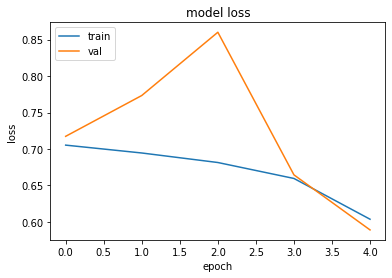

In [11]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_history(history)

- Model is clearly overfitting (one probable reason is the lack of training data.)
- On increasing the epochs, the model is clearly overfitting

## <u>Transfer Learning using Inception.</u>

In [23]:
# loading Inception
model2 = tf.keras.applications.InceptionV3(include_top=False, input_shape=(150,150,3))

In [24]:
# freezing layers
for layer in model2.layers:
    layer.trainable=False

In [25]:
# getting mixed7 layer
l = model2.get_layer("mixed7")

In [26]:
print ("mixed7 shape: {}".format(l.output_shape))

mixed7 shape: (None, 7, 7, 768)


In [27]:
x = tf.keras.layers.Flatten()(l.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(.5)(x)                  
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)           
net = tf.keras.Model(model2.input, x) 

In [28]:
net.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['acc'])

In [29]:
h2 = net.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5)

Epoch 1/5
14/14 [==============================] - 4s 118ms/step - loss: 2.4168 - acc: 0.5787 - val_loss: 0.5779 - val_acc: 0.7847
Epoch 2/5
14/14 [==============================] - 1s 44ms/step - loss: 0.8824 - acc: 0.7616 - val_loss: 0.4609 - val_acc: 0.8333
Epoch 3/5
14/14 [==============================] - 1s 45ms/step - loss: 0.2708 - acc: 0.8912 - val_loss: 0.2415 - val_acc: 0.8958
Epoch 4/5
14/14 [==============================] - 1s 45ms/step - loss: 0.1207 - acc: 0.9398 - val_loss: 0.2114 - val_acc: 0.9306
Epoch 5/5
14/14 [==============================] - 1s 47ms/step - loss: 0.0574 - acc: 0.9815 - val_loss: 0.1822 - val_acc: 0.9514


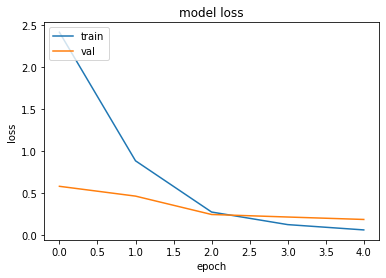

In [30]:
plot_history(h2)

- Clearly the model overfits after 3 epochs.
- But the result is still better than the previous one.

In [31]:
preds = net.predict(x_test)
pred_labels = []

In [32]:
# threshold is 0.5
for p in preds:
    if p >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
pred_labels = np.array(pred_labels)

In [33]:
print ("Accuracy on test set: {}".format(accuracy_score(y_test, pred_labels)))

Accuracy on test set: 0.8888888888888888


<p>
    These two approaches show that if we use transfer learning, we get much better results than using a plain CNN model.
    Keep in mind, these approaches do not learn the similarity function but these focus on the classifying whether the image in forged or real. There are still many ways we can improve our model, one is by augmenting data.
</p>

### With our third approach, we will try to learn the similarity function. We will use something called Siamese networks (due to nature of our data i.e less number of training examples)


# <u>Approach #3: Siamese networks for image similarity</u>
<p>
    In this approach, we will use Siamese networks to learn the similarity function. Siamese means 'twins' and the biggest difference between normal nn's is that these networks try to learn the approximate the similarity function instead of trying to classify.
    <hr><strong>Refer: https://arxiv.org/pdf/1709.08761.pdf</strong>
    </p>

- We first create a common feature vector for our images. We will pass two images (positive and negative) and use a contrastive loss function (Distance metric (l1 distance)) and in the end we squash the output between 1 and 0 (sigmoid) to get the final result.
![image.png](attachment:1f544865-466e-4696-af69-2a3dd5e820b9.png)

In [34]:
# the NN is the diagram
feature_vector = tf.keras.Sequential()
feature_vector.add(tf.keras.layers.Conv2D(64,3, activation='relu', input_shape=(150,150,3)))
feature_vector.add(tf.keras.layers.BatchNormalization())
feature_vector.add(tf.keras.layers.Conv2D(32,3, activation='relu'))
feature_vector.add(tf.keras.layers.BatchNormalization())
feature_vector.add(tf.keras.layers.Conv2D(16, 3,activation='relu'))
feature_vector.add(tf.keras.layers.MaxPool2D((2,2)))
feature_vector.add(tf.keras.layers.Flatten())
feature_vector.add(tf.keras.layers.Dropout(0.2))
feature_vector.add(tf.keras.layers.Dense(512, activation='relu'))

In [35]:
feature_vector.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_192 (Conv2D)         (None, 148, 148, 64)      1792      
                                                                 
 batch_normalization_188 (Ba  (None, 148, 148, 64)     256       
 tchNormalization)                                               
                                                                 
 conv2d_193 (Conv2D)         (None, 146, 146, 32)      18464     
                                                                 
 batch_normalization_189 (Ba  (None, 146, 146, 32)     128       
 tchNormalization)                                               
                                                                 
 conv2d_194 (Conv2D)         (None, 144, 144, 16)      4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 72, 72, 16)      

In [36]:
# creating the siamese network
im_a = tf.keras.layers.Input(shape=(150,150,3))
im_b = tf.keras.layers.Input(shape=(150,150,3))

encoded_a = feature_vector(im_a)
encoded_b = feature_vector(im_b)

combined = tf.keras.layers.concatenate([encoded_a, encoded_b])
combine = tf.keras.layers.BatchNormalization()(combined)
combined = tf.keras.layers.Dense(4, activation = 'linear')(combined)
combined = tf.keras.layers.BatchNormalization()(combined)
combined = tf.keras.layers.Activation('relu')(combined)
combined = tf.keras.layers.Dense(1, activation = 'sigmoid')(combined)

sm = tf.keras.Model(inputs=[im_a, im_b], outputs=[combined])
sm.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 512)          42493104    ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

In [37]:
sm.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

# <u>Dataset Generation</u>
<p>
    To generate the required dataset, we will try two approaches. First we will generate data on the basis of labels. If two images have the same label (1 or 0), then they are similar. We will generate data in pairs in the form (im_a, im_b, label).<br>
    Second we will generate data on the basis of person number. According to the dataset, 02104021.png represents the signature produced by person 21 (i.e real).
</p>

## Data generation Approach #1:
<p>
    Here we are assuming similarity on the basis of labels. If two images have the same label (i.e 1 or 0) then they are similar.
</p>

In [38]:
def generate_data_first_approach(features, labels, test_size=0.25):
    """
        Generate data in pairs according to labels.
        Arguments:
            features: numpy
            labels: numpy
    """
    im_a = [] # images a
    im_b = [] # images b
    pair_labels = []
    for i in range(0, len(features)-1):
        j = i + 1
        if labels[i] == 1 and labels[j]==1:
            im_a.append(features[i])
            im_b.append(features[j])
            pair_labels.append(1) # similar
        else:
            im_a.append(features[i])
            im_b.append(features[j])
            pair_labels.append(0) # not similar
            
    pairs = np.stack([im_a, im_b], axis=1)
    pair_labels = np.array(pair_labels)
    x_train, x_test, y_train, y_test = train_test_split(pairs, pair_labels, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
    return x_train, y_train, x_test, y_test, x_val, y_val, pairs, pair_labels

In [39]:
x_train, y_train, x_test, y_test, x_val, y_val, pairs, pair_labels = generate_data_first_approach(features, labels)

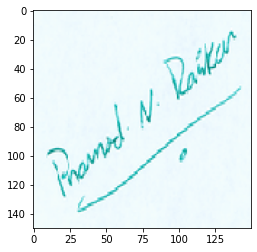

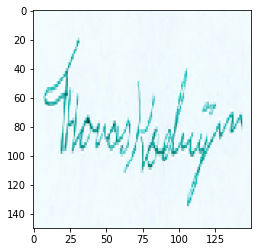

Label:  1


In [62]:
plt.imshow(pairs[:,0][0]/255.)
plt.show()
plt.imshow(pairs[:,1][0]/255.)
plt.show()
print("Label: ",pair_labels[100])

In [45]:
# x_train[:,0] => axis=1 (all 150,150,3) x_train[:,1] => axis=1 (second column)
sm.fit([x_train[:,0], x_train[:,1]], y_train, validation_data=([x_val[:,0],x_val[:,1]], y_val),epochs=50)

Epoch 1/50
13/13 [==============================] - 2s 157ms/step - loss: 0.4082 - mae: 0.3303 - val_loss: 0.1510 - val_mae: 0.1292
Epoch 2/50
13/13 [==============================] - 2s 149ms/step - loss: 0.3853 - mae: 0.3181 - val_loss: 0.3440 - val_mae: 0.2849
Epoch 3/50
13/13 [==============================] - 2s 149ms/step - loss: 0.3807 - mae: 0.3112 - val_loss: 0.3121 - val_mae: 0.2616
Epoch 4/50
13/13 [==============================] - 2s 147ms/step - loss: 0.3435 - mae: 0.2890 - val_loss: 0.3593 - val_mae: 0.2990
Epoch 5/50
13/13 [==============================] - 2s 149ms/step - loss: 0.3371 - mae: 0.2830 - val_loss: 0.3262 - val_mae: 0.2771
Epoch 6/50
13/13 [==============================] - 2s 149ms/step - loss: 0.3197 - mae: 0.2714 - val_loss: 0.3185 - val_mae: 0.2680
Epoch 7/50
13/13 [==============================] - 2s 149ms/step - loss: 0.3096 - mae: 0.2644 - val_loss: 0.3040 - val_mae: 0.2555
Epoch 8/50
13/13 [==============================] - 2s 149ms/step - loss: 0.

- The metric is calculating the L1-Distance (MAE) between the y_hat and y.
- Due to computation limitations,we only train it for one epoch
- This represents a very simple siamese network capable of learning the similarity function.

## Data Generation Approach #2
<p>
    In this approach, we try to setup a dataset where we cross multiply each signature with other number signature.<br>
    <strong> The inputs and the outputs must be the same size.</strong>
</p>

In [ ]:
def generate_data(person_number="001"):
    x = list(features_dict.keys())
    im_r = []
    im_f = []
    labels = [] # represents 1 if signature is real else 0
    for i in x:
        if i.startswith(person_number):
            if i.endswith("{}.png".format(person_number)):
                im_r.append(i)
                labels.append(1)
            else:
                im_f.append(i)
                labels.append(0)
    return im_r, im_f, labels


def generate_dataset_approach_two(size=100, test_size=0.25):
    """
        Generate data using the second approach.
        Remember input and output must be the same size!
        
        Arguments:
            features: numpy array
            labels: numpy array
            size: the target size (length of the array)
        Returns:
            x_train, y_train
    """
    im_r = []
    im_f = []
    ls = []

    ids = ["001","002","003",'004','005','006','007','008','009','010','011','012','013','014','015','016','017','018','019','020','021','022',
           '023','024','025','026','027','028','029','030']
    
    for i in ids:
        imr, imf, labels = generate_data(i)
        
        # similar batch
        for i in imr:
            for j in imr:
                im_r.append(img_to_array(features_dict[i][0]))
                im_f.append(img_to_array(features_dict[j][0]))
                ls.append(1) # they are similar
        
        # not similar batch
        for k in imf:
            for l in imf:
                im_r.append(img_to_array(features_dict[k][0]))
                im_f.append(img_to_array(features_dict[l][0]))
                ls.append(0) # they are not similar
    
    print(len(im_r), len(im_f))
    pairs = np.stack([im_r, im_f], axis=1)
    ls = np.array(ls)
    
    x_train, x_test, y_train, y_test = train_test_split(pairs, ls, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
    return x_train, y_train, x_test, y_test, x_val, y_val, pairs, ls    
        

In [ ]:
x_train, y_train, x_test, y_test, x_val, y_val, pairs, ls = generate_dataset_approach_two()

10781 10781


- Now we have the dataset generated. We will train the network.

In [ ]:
sm.fit([x_train[:,0], x_train[:,1]], y_train, epochs=1, validation_data=([x_test[:,0], x_test[:,1]], y_test))

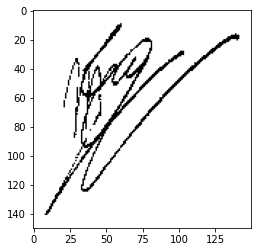

Label:  0


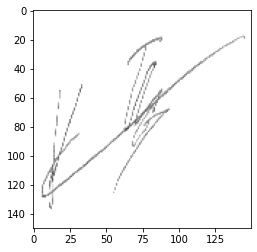

In [ ]:
plt.imshow(x_train[:,0][0]/255.)
plt.show()
plt.imshow(x_train[:,0][1]/255.)
print("Label: ",y_train[0])